In [25]:
import numpy as np
import csv
import os  
import astropy.stats as ap
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

## Goals 
1.Make a clipper from masked array

2.Find extras to add in

3.Unmask

# Functions

In [26]:
def maskclipper(x,y,sigma=3,iters=5):
    print("Starting MAclipping")
    cutoffs=[]
    xy=np.column_stack([x,y])
    xy2=xy[:,0]<min(xy[:,0])
    xy=np.ma.asarray(xy)
    for i in range(iters):
        
        medx=np.ma.median(xy[:,0][~xy[:,0].mask])
        medy=np.ma.median(xy[:,1][~xy[:,0].mask])
        
        
        xynorm=np.column_stack([xy[:,0]-medx,xy[:,1]-medy])
        norm=sum(np.linalg.norm(xynorm[~xy2],axis=1))
        
        xyz=np.column_stack([xy[:,0],xy[:,1],np.linalg.norm(xynorm,axis=1)])
        xyz=np.ma.asarray(xyz)
       
        
        xy2=np.ma.masked_greater(xyz[:,2],sigma*norm/(xy.count()/2)).mask
        stack=np.column_stack([xy2,xy2])
        
        cutoffs.append(sigma*norm/(xy.count()/2))
        print(medx,medy,xy.count()/2,sigma*norm/(xy.count()/2))
               
        xy=np.ma.MaskedArray(xy,mask=stack)
        print('=================================')
        
    medx=np.median(xy[:,0])
    medy=np.median(xy[:,1])
    test= np.column_stack([x-medx,y-medy])
    #all the points outside of the last clip
    cuts= np.linalg.norm(test,axis=1)>sigma*norm/(xy.count()/2)
    print('===========================================')
    return [medx,medy,cutoffs,xy]

'''[0]Medx-   Median in first variable
   [1]Medy-   Median in second variable
   [2]sigma*norm/xy.count()/2- the final radius cut circle
   [3]cuts-   Every element that is clipped
   [4]ab-     checking to see if it clips the same way as other method
   [5]xy-     final masked array
   '''

def ellipr(a,b,theta):
    return ((np.cos(theta)/a)**2. + (np.sin(theta)/b)**2.)**(-0.5) # returns radius

def dataRegion(fulldata,med,region):
    xdata=fulldata[0]-med[0]
    ydata=fulldata[1]-med[1]
    xydata=np.column_stack([xdata,ydata])
    norm=np.linalg.norm(xydata,axis=1)
    fullerdata=np.column_stack([xydata,norm])
    
    lowerregion=fullerdata[:,2]<region[1]
    higherregion=fullerdata[:,2]>region[0]
    finalindex=np.logical_and(lowerregion,higherregion)
    
    return finalindex

# Data

In [27]:
pmra,pmraerr,pmdec,pmdecerr = np.loadtxt('C:/Users/Erick/Desktop/OU REU/NGC663/ARE YOU NOT CORRECT/20PM.csv', skiprows=1,usecols=(7,8,9,10),unpack=True,delimiter=',')

medx,medy,rs,xy=maskclipper(pmra,pmdec)
finalr=rs[-1]
mask=xy[:,0].mask

Starting MAclipping
-1.1031976776 -0.280523935709 1584.0 3.17886689435
-1.11193369493 -0.272206100796 1446.0 2.142904462
-1.11287031056 -0.272145069533 1298.0 1.48743456959
-1.11167373167 -0.272105380393 1177.0 1.10666403927
-1.11264139728 -0.266197368138 1093.0 0.919145928333


C:\Users\Erick\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Full data plot and zoomed

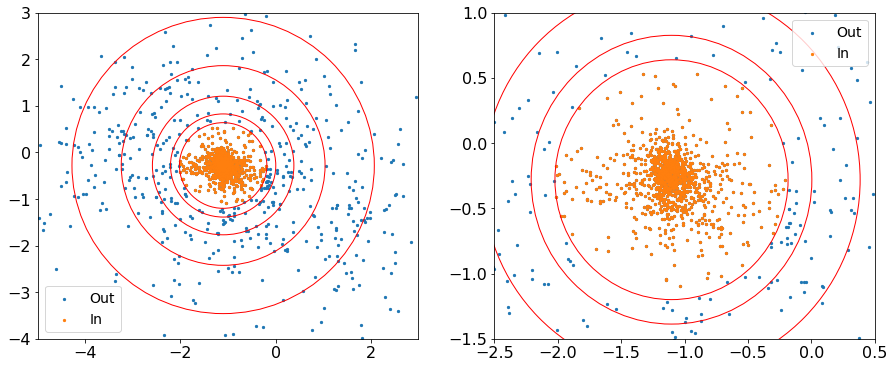

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(121)
for i in range(len(rs)):
    circle = plt.Circle((medx,medy), rs[i], color='r',fill=False)
    plt.gca().add_artist(circle)
plt.scatter(pmra,pmdec,s=5,label='Out')
plt.scatter(xy[:,0],xy[:,1],s=5,label='In')
plt.xlim(-5,3)
plt.ylim(-4,3)
plt.legend()

plt.subplot(122)
for i in range(len(rs)):
    circle = plt.Circle((medx,medy), rs[i], color='r',fill=False)
    plt.gca().add_artist(circle)
plt.scatter(pmra,pmdec,s=5,label='Out')
plt.scatter(xy[:,0],xy[:,1],s=5,label='In')
plt.xlim(-2.5,0.5)
plt.ylim(-1.5,1)
plt.legend()

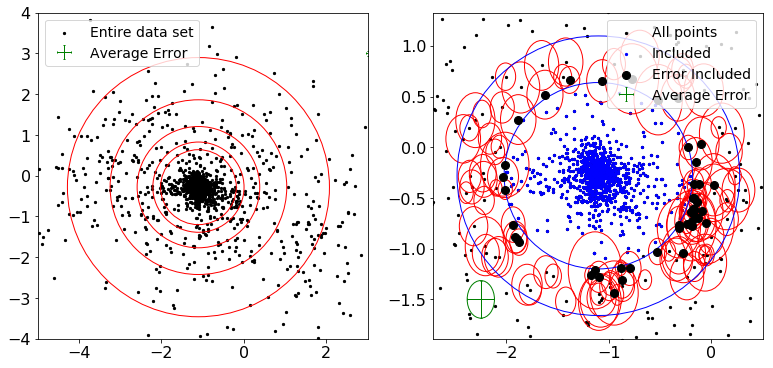

In [29]:
plt.figure(figsize=(13,6))


plt.subplot(1,2,1)
#plt.errorbar(pmra,pmdec,xerr=pmraerr,yerr=pmdecerr,fmt='none',capsize=1,linewidth=1,c='k')
plt.errorbar(3,3,xerr=np.average(pmraerr),yerr=np.average(pmdecerr),fmt='none',capsize=1,linewidth=1,c='g',label='Average Error')
plt.scatter(pmra,pmdec,s=5,c='k',label='Entire data set')
for i in range(len(rs)):
    circle = plt.Circle((medx,medy), rs[i], color='r',fill=False)
    plt.gca().add_artist(circle)


plt.ylim(-4,4)
plt.xlim(-5,3)
plt.legend()



plt.subplot(1,2,2)
#plt.errorbar(pmra,pmdec,xerr=pmraerr,yerr=pmdecerr,fmt='none',capsize=1,linewidth=1,c='k')

#Average Error bar/ellipse plotted visibly
plt.errorbar(-2.25,-1.5,xerr=3*np.average(pmraerr),yerr=3*np.average(pmdecerr),fmt='none',capstyle='butt',capsize=1,label='Average Error',linewidth=1,c='green')
ell=Ellipse((-2.25,-1.5),6*np.average(pmraerr),6*np.average(pmdecerr),fill=0,color='green')
plt.gca().add_artist(ell)

#Putting error ellipses on data points in region near cut
finalcut=dataRegion([pmra,pmdec],[medx,medy],[finalr,1.5*finalr])
regioncut=[pmra[finalcut],pmdec[finalcut],pmraerr[finalcut],pmdecerr[finalcut]]

ells2= [Ellipse(xy=(regioncut[0][i],regioncut[1][i]),width=6*regioncut[2][i],height=6*regioncut[3][i],fill=0,color='r') for i in range(len(regioncut[1]))]
ells = [Ellipse(xy=(pmra[i],pmdec[i]), width=2*pmraerr[i], height=2*pmdecerr[i], fill=0,color='r') for i in range(len(pmra))]
for e in ells2:
    plt.gca().add_artist(e)
    pass

plt.scatter(pmra,pmdec,s=5,c='k',label='All points')
plt.scatter(pmra[~mask],pmdec[~mask],s=5,c='b',label='Included')


#Finding the elements that cross with errors
x1=pmra[finalcut]-medx
y1=pmdec[finalcut]-medy
R= [(x**2+y**2)**.5 for x,y in zip(x1,y1)]
a1=pmraerr[finalcut]
b1=pmdecerr[finalcut]
theta=np.arctan2(y1,x1) 
r1=[ellipr(3*a,3*b,theta) for a,b,theta in zip(a1,b1,theta)]
r2=[ellipr(finalr,finalr,theta+np.pi) for a,b,theta in zip(a1,b1,theta)]
include=[a+b>c for a,b,c in zip(r1,r2,R)]
#plotting the points that actually are included
plt.scatter(x1[include] +medx,y1[include]+medy,zorder=2,color='k',label='Error Included')

plt.legend()
#Adding region circles and changing plot
circle = plt.Circle((medx,medy),finalr, color='b',fill=False)
plt.gca().add_artist(circle)
circle = plt.Circle((medx,medy),1.5*finalr, color='b',fill=False)
plt.gca().add_artist(circle)
plt.ylim(medy-1.75*finalr,medy+1.75*finalr)
plt.xlim(medx-1.75*finalr,medx+1.75*finalr)

plt.savefig('ClippingProcess.png')

#these are the pmra and pmdec that should be inluded into the final cut
unmaskthese=np.column_stack([x1[include] +medx,y1[include]+medy])

In [30]:
#this will find the indices that the value corresponds to in the qlist
def all_indices(value, qlist):
    indices = []
    wlist=[round(a,10) for a in qlist]
    idx = -1
    while True:
        try:
            idx = wlist.index(round(value,10), idx+1)
            indices.append(idx)
        except ValueError:
            break
    return indices

#this is going to find every indice that i need to unmask in my final masked array
indices=[]
for i in range(len(unmaskthese)):
    indices.append(all_indices(unmaskthese[i][0],list(pmra))[0])
    print('for',unmaskthese[i][0],'index is',indices[i])
    print('==================================')
print(indices)

#making my final masked array that is unmasked correctly
newxy=xy
for i in indices:
    xy[i].mask=[False, False]

#This is the mask i will apply to the original data for a text file
maskforeverything= xy[:,0].mask
print(maskforeverything)

for -0.138385466922 index is 16
for -0.190633281129 index is 24
for -0.104522065422 index is 52
for -0.0484095168257 index is 137
for -1.87942042718 index is 170
for -0.799074603928 index is 184
for -0.776127550217 index is 189
for -0.170454849232 index is 217
for -0.519799126623 index is 219
for -2.01237766533 index is 226
for 0.0217240449682 index is 243
for -0.154025334382 index is 275
for -0.317604107406 index is 300
for -0.173835414662 index is 312
for -1.09911188398 index is 364
for -0.173093059518 index is 378
for -0.949581739052 index is 406
for -1.88479548377 index is 407
for -0.870856682941 index is 420
for -0.0901469063224 index is 565
for -1.93459718792 index is 593
for -1.0643575233 index is 599
for -0.12960549618 index is 611
for -0.526327320324 index is 629
for -0.328191292071 index is 797
for -1.90179507415 index is 798
for -0.178098378236 index is 805
for -1.38403465304 index is 817
for -0.315235906303 index is 865
for -0.198960524283 index is 950
for -2.01663888217 in

In [31]:
#This is to show why i need to round
j=0
k=0
for i in indices:
    k=k+(pmra[i]==unmaskthese[j][0])
    #print(pmra[i]==unmaskthese[j][0])
    j=j+1

h=0
j=0
for i in indices:
    h=h+(round(pmra[i],10)==round(unmaskthese[j][0],10))
    #print(round(pmra[i],10)==round(unmaskthese[j][0],10))
    j=j+1
    
print('not rounded is:',k/len(unmaskthese),'rounded is:',h/len(unmaskthese))

not rounded is: 0.727272727273 rounded is: 1.0


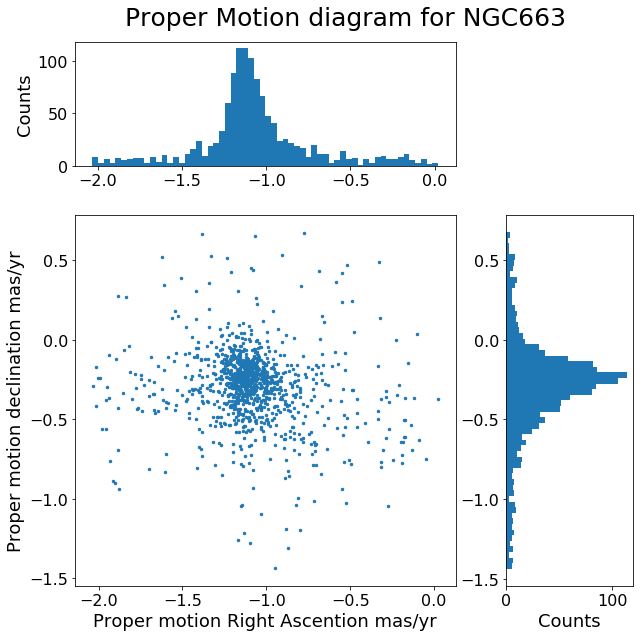

In [32]:
from matplotlib import gridspec

gm=maskforeverything
plt.figure(figsize=(10,10))
gs= gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,3])
plt.subplot(gs[2])
plt.scatter(newxy[:,0],newxy[:,1],s=6)
plt.ylabel('Proper motion declination mas/yr')
plt.xlabel('Proper motion Right Ascention mas/yr')

plt.subplot(gs[0])
plt.ylabel('Counts')
plt.hist(newxy[:,0],bins=60)


plt.subplot(gs[3])
plt.xlabel('Counts')
plt.hist(newxy[:,1],bins=60,orientation='horizontal')

plt.suptitle('Proper Motion diagram for NGC663',y=.93, fontsize=25)
plt.savefig('ProperMotionNGC663.png')

In [33]:
print(gm)

[False  True False ..., False  True False]


# GAIA-ID, RA, Dec, GAIA Distance

In [39]:
gaiaid=np.loadtxt('C:/Users/Erick/Desktop/OU REU/NGC663/ARE YOU NOT CORRECT/20PM.csv', skiprows=1,usecols=(0),unpack=True,delimiter=',')
print(int(gaiaid[0]))

511191306841866880
